### Import modules

In [10]:
# THIS NOTEBOOK WAS RUN ON A KAGGLE KERNEL

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# General
import os
import random
import time

# Data processing, storage
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Image processing
import cv2 # opencv-python
from PIL import Image

# Data plotting
import matplotlib.pyplot as plt

# Machine learning
import tensorflow as tf
from sklearn import metrics

### Test GPU availability

In [11]:
tf.__version__

'2.4.1'

In [12]:
# Check if tensorflow can find GPU
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [13]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)
print(gpus)

Name: /physical_device:GPU:0   Type: GPU
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5750067442850613864,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15685569792
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11173559049641122733
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [15]:
tf.test.is_gpu_available()

True

In [16]:
!nvidia-smi

Sat Apr 17 14:57:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    33W / 250W |    367MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Check input data availability

In [17]:

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname, "contains", len(filenames), "files.")
    #for filename in filenames:
    #    print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input contains 0 files.
/kaggle/input/p7eglmltilesshiftrotate200regionsclean contains 0 files.
/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean contains 1 files.
/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/test contains 0 files.
/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/test/EGL contains 975 files.
/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/test/ML contains 600 files.
/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/train contains 0 files.
/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/train/EGL contains 3900 files.
/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/train/ML contains 2800 files.


### Set parameters

In [18]:
basedatadir = '/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean'

train_data_dir = basedatadir + '/train'
test_data_dir = basedatadir + '/test'

# Calculation of max batch size-
# Max batch size= available GPU memory bytes / 4 / (size of tensors + trainable parameters)
# size of tensors = batch_size*100*100 *4 if using 64 bit integers

batch_size = 64#256
test_batch_size = 64#256
img_height = 300
img_width = 300
channels = 1
#mean = 157.1
#std = 64.6
AUTOTUNE = tf.data.experimental.AUTOTUNE

### Calculate mean and standard deviation of training dataset

In [19]:
filenames = []
for label in os.listdir(train_data_dir):
    for filename in os.listdir(train_data_dir+"/"+label):
        if filename.endswith(".png"):
            filenames.append(train_data_dir+"/"+label+"/"+filename)
n_train_images = len(filenames)
print("Total number of png files:", n_train_images)

Total number of png files: 6700


### Optional: Check how much space will be required.

In [20]:
# Optional: Check how much space will be required.
s="""
tic = time.time() # Start time

x = np.ndarray((n_train_images,img_height,img_width), dtype='uint8')

toc = time.time() # End time
time_elapsed = 1000*(toc-tic)

print("Memory occupied by ndarray:", x.nbytes, "bytes,", x.nbytes/1000000000, "gigabytes")
print("Time elapsed:", time_elapsed, "ms")
print("ID of x:", id(x))
#del(x)
"""

In [21]:
# Read images and store in the ndarray allocated above
s="""
tic = time.time() # Start time

#x = np.array([cv2.imread(filename, 0) for filename in filenames[:n_images]])

cnt = 0
for filename in filenames[:n_train_images]:
    x[cnt] = cv2.imread(filename, 0)
    #if(cnt%1000 == 0):
    #    print(cnt, time.time()-tic)
    cnt += 1

toc = time.time()
time_elapsed = 1000*(toc-tic)

print("Memory occupied by ndarray:", x.nbytes, "bytes,", x.nbytes/1000000000, "gigabytes")
print("Time elapsed:", time_elapsed, "ms")
print("ID of x:", id(x))
print()

# Calculate mean and std
mean = x.mean()
print("Mean =", mean)
std = x.std()
print("Stardard devition =", std)
del(filenames)
del(x)
"""

### Create FileList datasets
tf.data.Dataset.list_files() creates a dataset from a directory list of files using a matching pattern.

In [22]:
# Get the count of image files in the train directory
train_list_ds = tf.data.Dataset.list_files(str(train_data_dir + '/*/*'), shuffle=False)
train_image_count=0
for dir1 in os.listdir(train_data_dir):
    for files in os.listdir(os.path.join(train_data_dir, dir1)):
        train_image_count+=1
train_list_ds = train_list_ds.shuffle(train_image_count, reshuffle_each_iteration=False)
print("Train image coung:", train_image_count)

Train image coung: 6700


In [23]:
# Print some filenames
for x in train_list_ds.take(5):
    print(x.numpy().decode('utf-8'))

/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/train/ML/R142_(24880,22144,2135)_rot45.png
/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/train/ML/R142_(25180,22144,2135)_rot30.png
/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/train/EGL/R70_(42240,9600,2020)_rot45.png
/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/train/EGL/R74_(33236,11360,2334).png
/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/train/EGL/R138_(20240,11232,886)_rot45.png


In [24]:
# Get the count of image files in the test directory
test_list_ds = tf.data.Dataset.list_files(str(test_data_dir + '/*/*'), shuffle=False)
test_image_count=0
for dir1 in os.listdir(test_data_dir):
    for files in os.listdir(os.path.join(test_data_dir, dir1)):
        test_image_count+=1
test_list_ds = test_list_ds.shuffle(test_image_count, reshuffle_each_iteration=False)
print("Test image count:", test_image_count)

Test image count: 1575


In [25]:
# Print some filenames
for x in test_list_ds.take(5):
    print(x.numpy().decode('utf-8'))

/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/test/EGL/R184_(22816,10884,2134)_rot90.png
/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/test/ML/R177_(17636,24464,931)_rot30.png
/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/test/EGL/R193_(30512,11248,2371)_rot90.png
/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/test/EGL/R86_(39104,9188,2502)_rot90.png
/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/test/EGL/R60_(22080,13292,1820)_rot30.png


### Function to create list of files from tensorflow dataset

In [26]:
# Use this function to list files from a filelist dataset, such as test_list_ds.
# This may be useful later.
list_files_from_tfdataset = lambda tfd: [f.numpy().decode('utf-8') for f in tfd]

In [27]:
#l = list_files_from_tfdataset(test_list_ds)
#print(len(l))
#del(l)
#test_ds_filepaths = test_list_ds.take(test_image_count)

### Create class labels from the directory name

In [28]:
class_names = np.array(sorted([dir1 for dir1 in os.listdir(train_data_dir)]))
print("Class names:", class_names)

Class names: ['EGL' 'ML']


### Split the dataset into train and val (Note that test dataset is already kept separate)
The validation dataset is 30% of the total dataset, and train dataset is 70% of the entire dataset.

In [29]:
# Create training and validation datasets
val_size = int(train_image_count * 0.3)
train_ds = train_list_ds.skip(val_size)
val_ds = train_list_ds.take(val_size)
print("Training images:", train_image_count-val_size, "\nValidation images:", val_size)

Training images: 4690 
Validation images: 2010


In [30]:
# Different way of creating training and validation datasets:
# This is useful to select only a small subset of the full data
#val_size = int(train_image_count * 0.01)
#train_size = int(train_image_count * 0.03)
#train_ds = train_list_ds.take(train_size)
#remaining_list_ds = train_list_ds.skip(train_size)
#val_ds = remaining_list_ds.take(val_size)
#print("Training images:", train_size, "\nValidation images:", val_size)

In [31]:
# Create test dataset
test_ds = test_list_ds.take(test_image_count)

In [32]:
# Print some filenames
print("Files from train_ds")
for x in train_ds.take(3):
    print(x.numpy().decode('utf-8'))
print("Files from val_ds")
for x in val_ds.take(3):
    print(x.numpy().decode('utf-8'))
print("Files from test_ds")
for x in test_ds.take(3):
    print(x.numpy().decode('utf-8'))

Files from train_ds
/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/train/ML/R127_(21308,21728,2322)_rot45.png
/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/train/EGL/R6_(11552,17020,0).png
/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/train/EGL/R118_(13344,11524,428)_rot45.png
Files from val_ds
/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/train/ML/R142_(24880,22144,2135)_rot45.png
/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/train/ML/R142_(25180,22144,2135)_rot30.png
/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/train/EGL/R70_(42240,9600,2020)_rot45.png
Files from test_ds
/kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/tes

### Create input pipeline components for a single training/validation example,<br>where a pair of tensors represents the image and its corresponding label.

In [33]:
#To process the label
def get_label(filepath):
    # convert the path to a list of path components separated by sep
    parts = tf.strings.split(filepath, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(tf.cast(one_hot, tf.int32))
    
    #label = tf.strings.split(filepath, sep='/')
    #label = tf.strings.split(label[-1], sep='.')

# To process the image
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    #img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.decode_png(img, channels=channels)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

# To create the single training of validation example with image and its corresponding label
def process_path(filepath):
    label = get_label(filepath)
    # load the raw data from the file as a string
    img = tf.io.read_file(filepath)
    img = decode_img(img)
    return img, label

### Create tf dataset of tensor by mapping the above functions to the filelist datasets<br>
Set the AUTOTUNE. This will help to delegate the decision on the level of parallelism<br>to use the tf.data at runtime and optimize the CPU/GPU utilization.

In [34]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [35]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [36]:
# Test if the datasets are prepared correctly
for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)
    img = images[0].numpy()
    print(img.min(), img.max(), img.dtype, labels.numpy())
    img = (img-5)/2 # Testing mathematical operations on tensor
    print(img.min(), img.max(), img.dtype, labels.numpy())

(300, 300, 1) ()
70.0 229.0 float32 1
32.5 112.0 float32 1


### Set augmentation and normalization functions

In [37]:
# Augmentation seeds and constants
seed_max = 1000
seed_prob25 = int(seed_max/4)
seed_prob50 = int(seed_max/2)

def augment(image, label):
    # Set a random seed
    seed = random.randint(1,seed_max)
    img = image
    if seed > seed_prob50:
        img = tf.image.rot90(img)
        img = tf.image.flip_left_right(img)

    img = tf.image.stateless_random_brightness(img, max_delta=0.4, seed=(seed,0))
    img = tf.image.stateless_random_contrast(img, lower=0.2, upper=0.6, seed=(seed,0))
    
    #img = tf.clip_by_value(img, 0.0, 1.0)
    return img, label

def standardize_per_image(image, label):
    img = tf.image.per_image_standardization(image)
    return img, label

def standardize_dataset(image, label):
    # NOTE: mean and std have to be defined globally
    # Not checking that mean and std are > 0 to avoid time lag. So be careful with the values of mean and std.
    img = (image - mean)/std
    return img, label

### Configure data source for Performance
To configure the data source for performance, use prefetching. Prefetching in tf.data allows the preprocessing of the data and model execution of a training step to overlap. While the model is executing a training step 100, the input pipeline is reading the data for step 101.

In [38]:
def configure_for_performance(ds, cache_filename=''):
    if cache_filename == '':
        ds = ds.cache()
    else:
        ds = ds.cache(cache_filename)
    ds = ds.shuffle(buffer_size=10000)
    ds = ds.map(augment, num_parallel_calls=AUTOTUNE) # No need if pre-augmented images.
    ds = ds.map(standardize_per_image, num_parallel_calls=AUTOTUNE) # Use either of the two standardizations.
    #ds = ds.map(standardize_dataset, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds, cache_filename='')#, '/home/harsh/tensorflow_cache/train_v5.train_ds')
val_ds = configure_for_performance(val_ds, cache_filename='')#, '/home/harsh/tensorflow_cache/train_v5.val_ds')

In [39]:
def configure_for_performance_forTestDataset(ds, cache_filename=''):
    if cache_filename == '':
        ds = ds.cache()
    else:
        ds = ds.cache(cache_filename)
    #ds = ds.shuffle(buffer_size=10000)
    ds = ds.map(standardize_per_image, num_parallel_calls=AUTOTUNE) # Use either of the two standardizations.
    #ds = ds.map(standardize_dataset, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(test_batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

test_ds = configure_for_performance_forTestDataset(test_ds, cache_filename='')#, '/home/harsh/tensorflow_cache/train_v5.test_ds')

(64, 300, 300, 1) (64,)
-6.0019226 2.6563668 float32 1


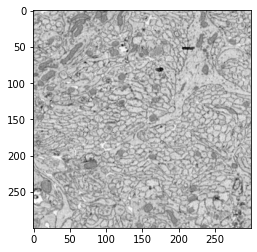

In [40]:
# Check that the pixels values are actually standardized and the images are properly stored.
for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)
    img = images[0].numpy()
    print(img.min(), img.max(), img.dtype, labels[0].numpy())
    plt.imshow(img, cmap=plt.get_cmap("gray"))

In [42]:
# Check the test dataset. This dataset is not shuffled.
# So you should see the same values printed if you run it again.
for images, labels in test_ds.take(1):
    print(images.shape, labels.shape)
    #img = images[0].numpy()
    print(images[0].numpy().min(), images[0].numpy().max())
    print(images[24].numpy().min(), images[24].numpy().max())

(64, 300, 300, 1) (64,)
-6.3818183 2.4240038
-4.551785 3.0202477


In [43]:
# Check if the file names can be matched with output of the test dataset
test_ds_filelist = list_files_from_tfdataset(test_list_ds) # Create test dataset file list.

(64, 300, 300, 1) (64,)
(300, 300, 1) ()
Class label: 1
Class name: ML
File name: /kaggle/input/p7eglmltilesshiftrotate200regionsclean/P7-EGL-ML-tiles-shift-rotate_200regions_clean/test/ML/R186_(19792,26116,797).png


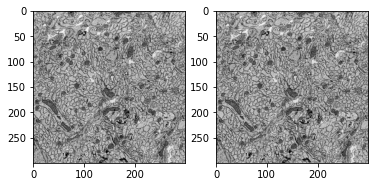

In [45]:
# Choose an image and it's filename from the dataset.
# Plot the tensor image as well as image given by the filename to see if they match.
num = 20
for images, labels in test_ds.take(1):
    print(images.shape, labels.shape)
    #plt.imshow(images[num].numpy()[:,:], cmap=plt.get_cmap("gray"))
    print(images[num].numpy().shape, labels[num].numpy().shape)
    print("Class label:", labels[num].numpy())
    print("Class name:", class_names[labels[num].numpy()])
    print("File name:", test_ds_filelist[num])

f = plt.figure()

f.add_subplot(1,2, 1)
test_img = cv2.imread(test_ds_filelist[num], 0)
plt.imshow(images[num].numpy()[:,:], cmap=plt.get_cmap("gray"))

f.add_subplot(1,2, 2)
plt.imshow(test_img, cmap=plt.get_cmap("gray"))

plt.show(block=True)


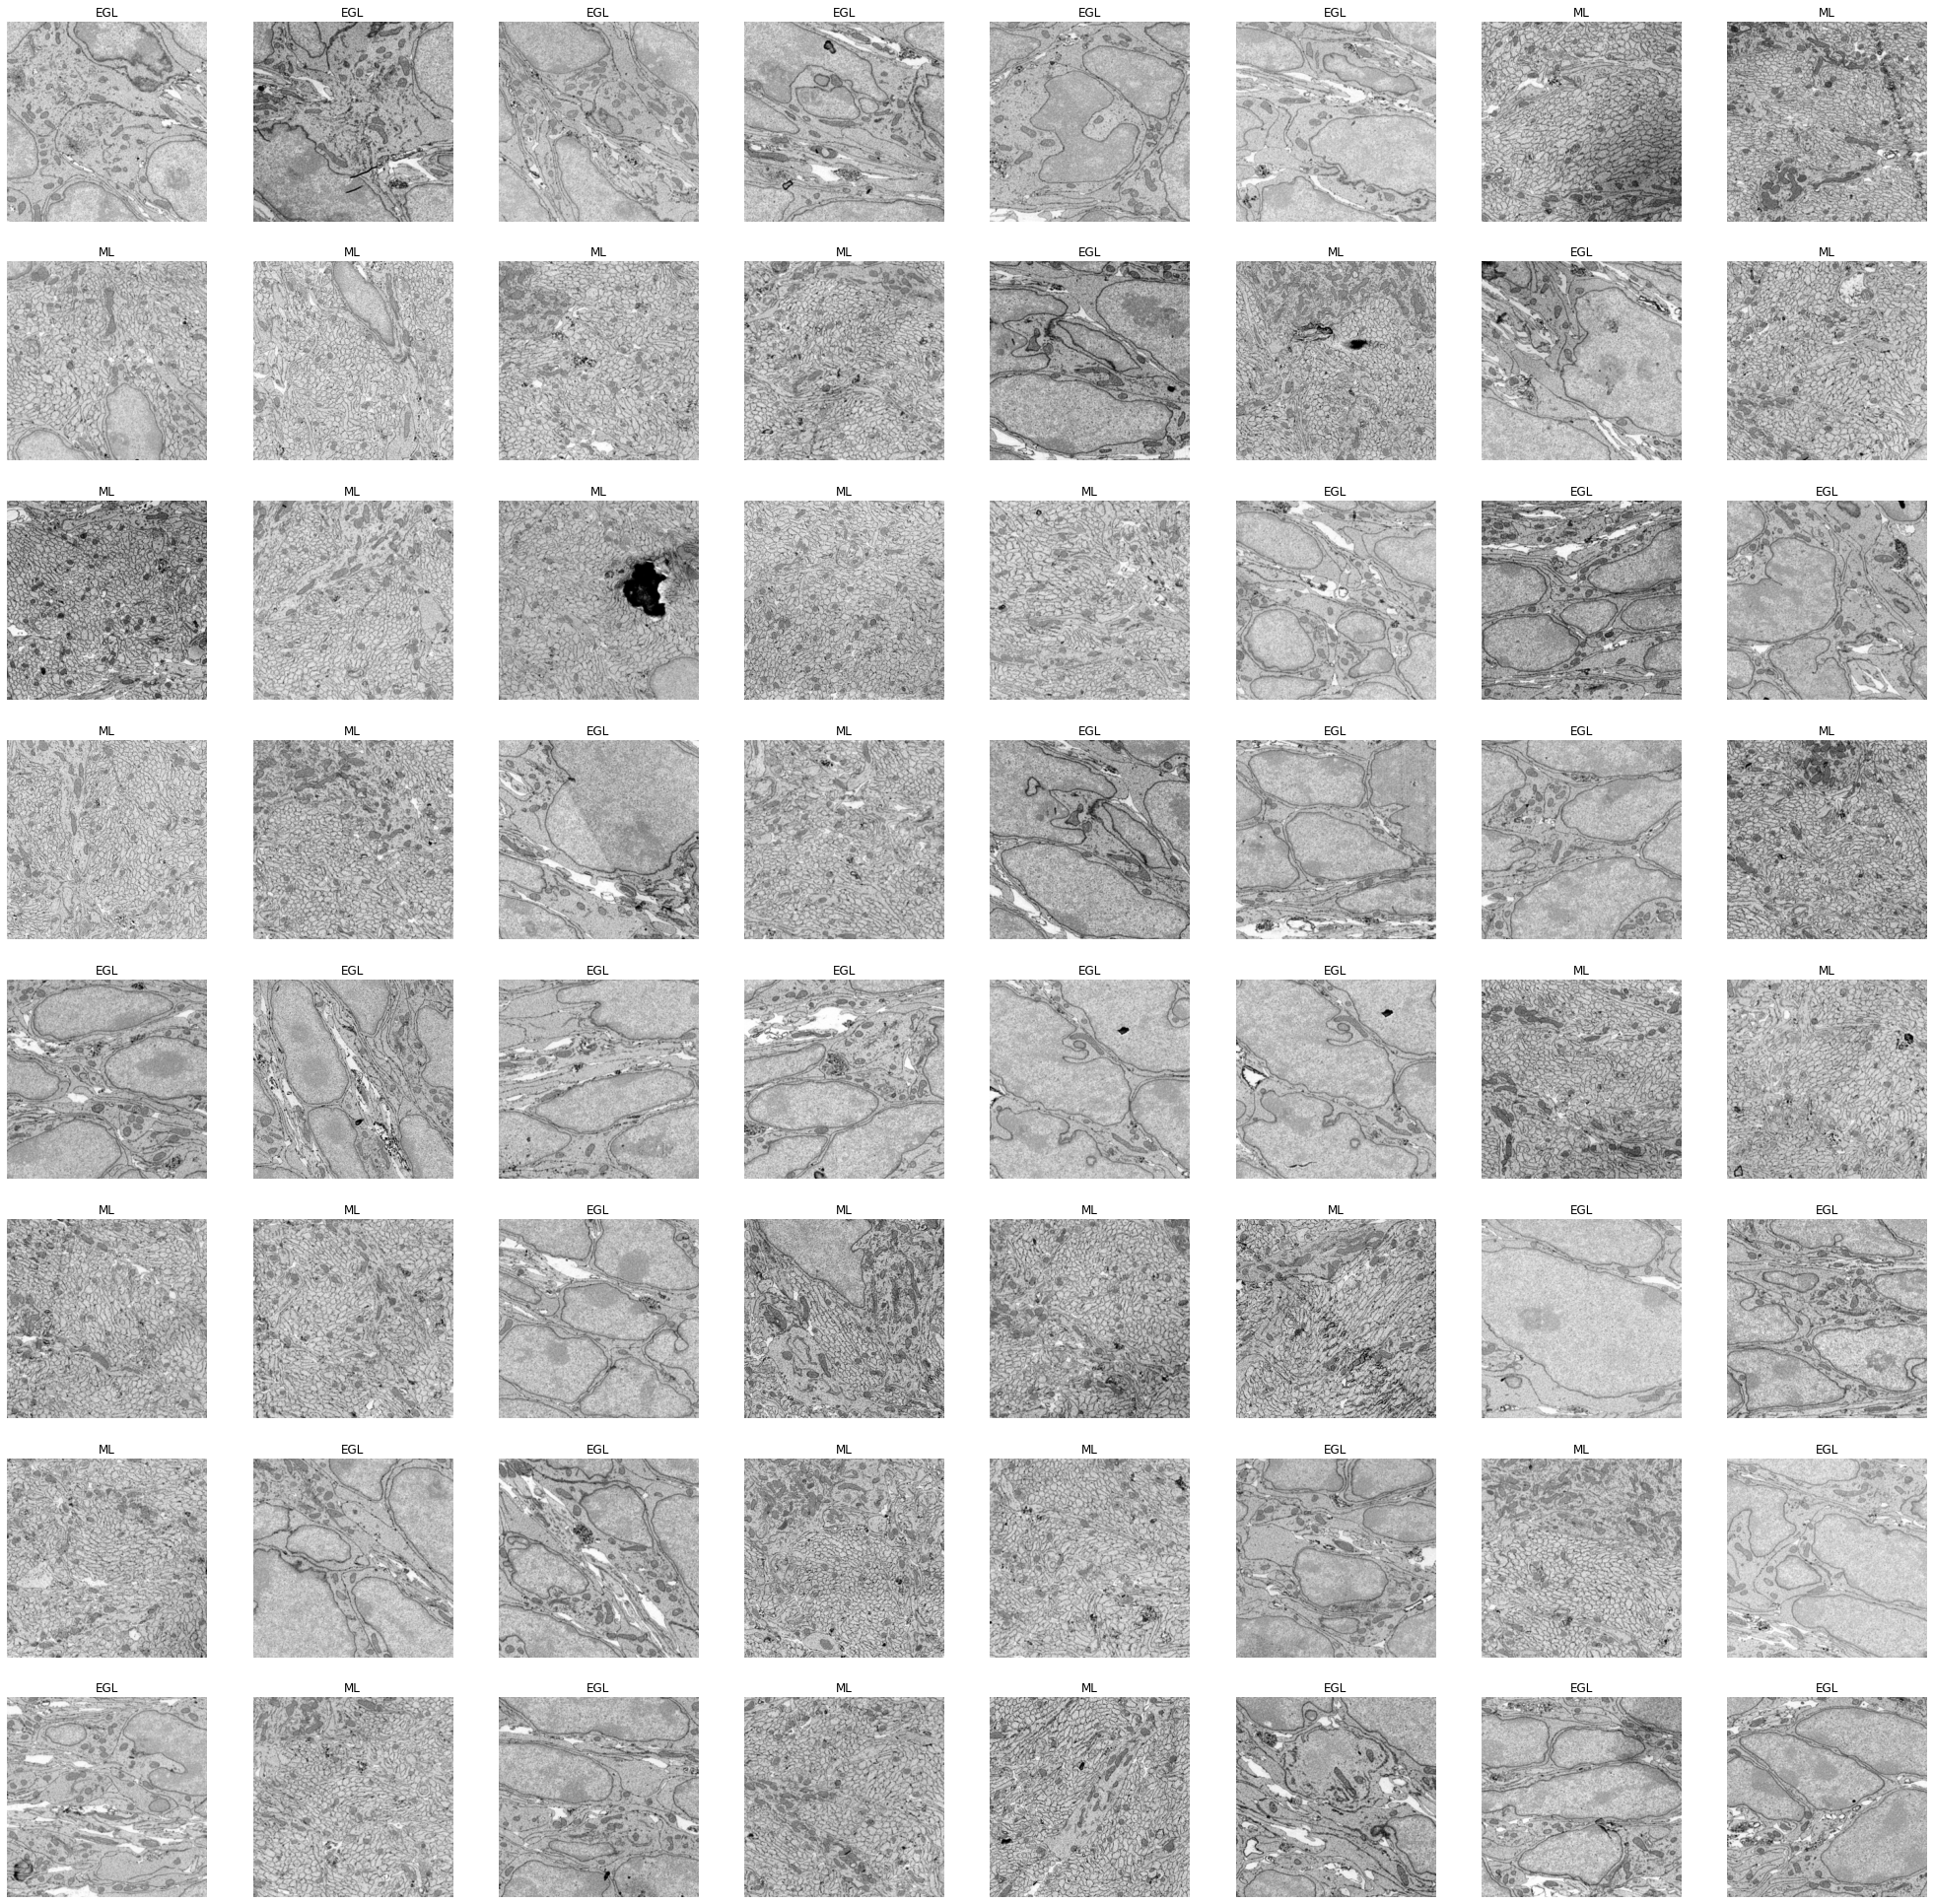

In [258]:
# Check if a batch of images from test dataset can be printed along with classnames and filenames
plt.figure(figsize=(35, 35))
cnt = 0
for images, labels in train_ds.take(1):
    #print(images.shape)
    for i in range(batch_size):
        ax = plt.subplot(int(np.sqrt(batch_size)), int(np.sqrt(batch_size)), i + 1)
        #ax = plt.subplot(16, 16, i + 1)
        #print(images[i].shape)
        plt.imshow(images[i].numpy(), cmap=plt.get_cmap("gray"))
        plt.title(class_names[labels[i]])
        #plt.title(class_names[labels[i]]+"\n"+test_ds_filelist[i+cnt*batch_size].split("/")[-1].replace(".png",""))
        plt.axis("off")
    cnt += 1

### Create Keras model

In [333]:
#Define model
def create_model():
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

    model=tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 1)),
            ###keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.Conv2D(32,(3,3), padding="same", activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(32,(3,3), padding="same", activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(64,(3,3), padding="same", activation='relu'),
            tf.keras.layers.MaxPool2D(2,2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    #Compile the model
    model.compile(
                  optimizer=opt, 
                  #optimizer='adam', 
                  loss='binary_crossentropy',
                  #loss='categorical_crossentropy',
                  metrics=['acc']
                  #metrics=['accuracy', 'f1score', 'precision', 'recall']
                 )

    return(model)

model = create_model()

#Print model summary
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_151 (Conv2D)          (None, 300, 300, 32)      320       
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_114 (MaxPoolin (None, 37, 37, 64)        0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 87616)           

In [334]:
# Visualize model graphically
#tf.keras.utils.plot_model(model)

In [335]:
models_dir = "/kaggle/working/models/training.V1"
try:
    os.mkdir(models_dir)
except:
    print("Directory exists:", models_dir)

checkpoint_path = models_dir+"/model.{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

Directory exists: /kaggle/working/models/training.V1


In [336]:
# Save the weights at epoch 0 using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

### Fit model to data

In [337]:
#Fitting the model
n_epochs = 20
history = model.fit(train_ds,
                    #steps_per_epoch=100,#(image_count-val_size) // batch_size,
                    epochs=n_epochs,
                    #validation_steps=100,#val_size // batch_size,
                    validation_data=val_ds,
                    callbacks=[cp_callback],
                    verbose=1
                   )

Epoch 1/20
74/74 [==============================] - 10s 125ms/step - loss: 0.3373 - acc: 0.8537 - val_loss: 6.4154 - val_acc: 0.4149

Epoch 00001: val_loss improved from inf to 6.41539, saving model to /kaggle/working/models/training.V1/model.0001.ckpt
Epoch 2/20
74/74 [==============================] - 9s 120ms/step - loss: 0.0219 - acc: 0.9971 - val_loss: 0.2786 - val_acc: 0.8697

Epoch 00002: val_loss improved from 6.41539 to 0.27857, saving model to /kaggle/working/models/training.V1/model.0002.ckpt
Epoch 3/20
74/74 [==============================] - 9s 121ms/step - loss: 0.0078 - acc: 0.9993 - val_loss: 0.0118 - val_acc: 0.9960

Epoch 00003: val_loss improved from 0.27857 to 0.01181, saving model to /kaggle/working/models/training.V1/model.0003.ckpt
Epoch 4/20
74/74 [==============================] - 8s 113ms/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.0094 - val_acc: 0.9980

Epoch 00004: val_loss improved from 0.01181 to 0.00938, saving model to /kaggle/working/models/trainin

### Save model to file

In [323]:
# Set up models output directory
#print(os.getcwd())
#models_dir = "/kaggle/working/models"
#os.mkdir(models_dir)
#print(os.listdir())

In [324]:
#model_filename = "models/model.10dec2020.data_mip3_aug.per_image_dataset"
#model_filename = models_dir + "/model1.P7-EGL-ML-shift-rotate-200regions.V6"
#model.save(model_filename)

### Access model performance

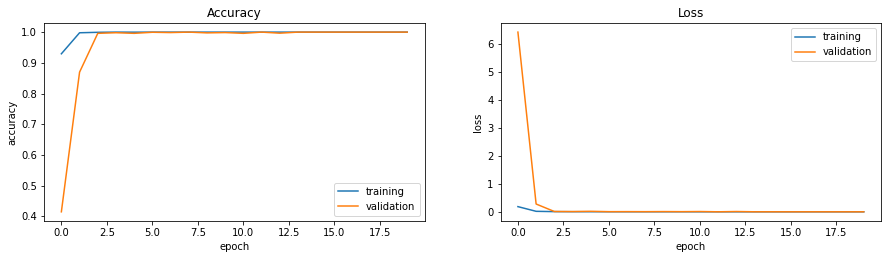

In [338]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('Accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['training', 'validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['training', 'validation']) 

plt.show()

In [339]:
#Calculate prediction loss and accuracy
test_pred = model.evaluate(test_ds)

25/25 [==============================] - 1s 29ms/step - loss: 0.0040 - acc: 0.9987


In [340]:
print("Prediction- Loss, Accuracy:", test_pred)

Prediction- Loss, Accuracy: [0.004038664046674967, 0.9987301826477051]


### Generate classification report

In [341]:
def classification_report(true_labels, pred_labels):
    print("---Classification report---\n")
    confusion_matrix = metrics.confusion_matrix(true_labels, pred_labels)
    print("\t\t\tClassified as")
    print("\t\t"+"\t".join(class_names)+"\tsum")
    for i in range(0,len(class_names)):
        print(class_names[i]+"\t"+
              "\t\t".join([str(x) for x in confusion_matrix[i]])+
              "\t\t"+str(np.sum(confusion_matrix[i])))
    print("==========================================================\n")
    print("F1 scores:",metrics.f1_score(true_labels, pred_labels, average=None))
    print("==========================================================\n")
    print("metrics.classification_report:\n",metrics.classification_report(true_labels, pred_labels))

In [342]:
def get_true_pred_labels(model, dataset, num_batches):
    pred_1_to_10 = []
    pred_labels = []
    true_labels = []
    cnt = 0
    for images, labels in dataset.take(num_batches):
        #3print(images.shape, labels.shape)
        pred = model.predict(images)
        pred_temp = (pred*10).astype(int)
        #pred_temp = pred_temp.astype(int)
        #print(pred.shape, pred[:5].astype(int))
        #print(pred.shape)
        for i in range(0,pred.shape[0]):
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[int(pred[i][0]>0.5)]
            true_labels.append(true_label)
            pred_labels.append(pred_label)
            ##if true_label ==  'connection' and pred_label == 'no_connection':
                # ???Save image- Saving image is still under review
                #print(images[i].shape)
                #print(type(image), image.shape, image.min(), image.max())
                #img = Image.fromarray(np.array(255*image)).convert("L")#"RGB")#(images[i].numpy())#.astype('uint8'))
                #img.save("data_mip3/test_connection_as_noconnection/image_"+str(cnt)+".png")
                ##image = images[i].numpy()
                ##image = np.squeeze(image)
                ##image = images[5].astype('uint8')
                ##Image.fromarray(images[6].astype('uint8')).save("image_6.png")

            pred_1_to_10.append(pred_temp[i])
            cnt += 1
    pred_1_to_10 = np.array(pred_1_to_10)
    plt.hist(pred_1_to_10, bins=10) # This is to see histogram of predictions
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    print(true_labels.shape, pred_labels.shape)
    print("Unique counts in true_labels:", np.unique(true_labels, return_counts=True))
    print("Unique counts in pred_labels:", np.unique(pred_labels, return_counts=True))
    print()
    return(true_labels, pred_labels)

(1575,) (1575,)
Unique counts in true_labels: (array(['EGL', 'ML'], dtype='<U3'), array([975, 600]))
Unique counts in pred_labels: (array(['EGL', 'ML'], dtype='<U3'), array([977, 598]))

---Classification report---

			Classified as
		EGL	ML	sum
EGL	975		0		975
ML	2		598		600

F1 scores: [0.99897541 0.99833055]

metrics.classification_report:
               precision    recall  f1-score   support

         EGL       1.00      1.00      1.00       975
          ML       1.00      1.00      1.00       600

    accuracy                           1.00      1575
   macro avg       1.00      1.00      1.00      1575
weighted avg       1.00      1.00      1.00      1575



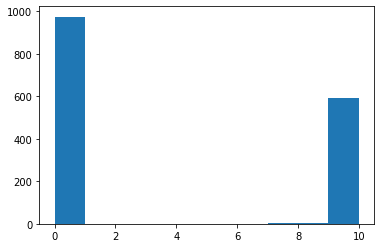

In [343]:
# Classification report for test dataset
true_labels, pred_labels = get_true_pred_labels(model, test_ds, 200)
classification_report(true_labels, pred_labels)

(4690,) (4690,)
Unique counts in true_labels: (array(['EGL', 'ML'], dtype='<U3'), array([2724, 1966]))
Unique counts in pred_labels: (array(['EGL', 'ML'], dtype='<U3'), array([2724, 1966]))

---Classification report---

			Classified as
		EGL	ML	sum
EGL	2724		0		2724
ML	0		1966		1966

F1 scores: [1. 1.]

metrics.classification_report:
               precision    recall  f1-score   support

         EGL       1.00      1.00      1.00      2724
          ML       1.00      1.00      1.00      1966

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690



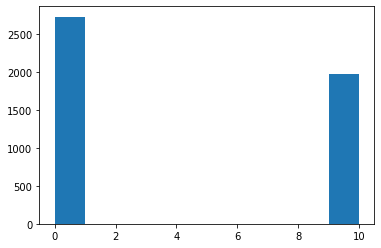

In [344]:
# Classification report for training dataset
true_labels, pred_labels = get_true_pred_labels(model, train_ds, 100)
classification_report(true_labels, pred_labels)

(2010,) (2010,)
Unique counts in true_labels: (array(['EGL', 'ML'], dtype='<U3'), array([1176,  834]))
Unique counts in pred_labels: (array(['EGL', 'ML'], dtype='<U3'), array([1176,  834]))

---Classification report---

			Classified as
		EGL	ML	sum
EGL	1176		0		1176
ML	0		834		834

F1 scores: [1. 1.]

metrics.classification_report:
               precision    recall  f1-score   support

         EGL       1.00      1.00      1.00      1176
          ML       1.00      1.00      1.00       834

    accuracy                           1.00      2010
   macro avg       1.00      1.00      1.00      2010
weighted avg       1.00      1.00      1.00      2010



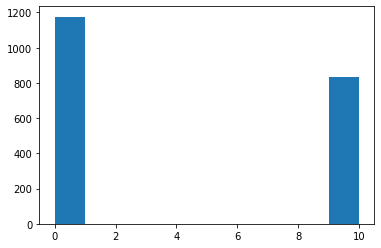

In [345]:
# Classification report for validation dataset
true_labels, pred_labels = get_true_pred_labels(model, val_ds, 100)
classification_report(true_labels, pred_labels)

### Check that the model was saved correctly and can be loaded again.

In [ ]:
# Get latest checkpoint
#latest_cp = tf.train.latest_checkpoint(checkpoint_dir)
#latest_cp

In [ ]:
# Create model and load weights
#model = create_model()
#model.load_weights('models/training.V1/model.0010.ckpt')
##model.load_weights(latest_cp)

### -------------- END OF THE NOTEBOOK --------------